# Gradient Boosting

## Import depuis sql

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet,  Ridge, Lasso
from sklearn.model_selection import learning_curve
import joblib

In [18]:
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os

In [19]:
load_dotenv()

True

In [20]:
user = os.getenv("PGUSER")
password = os.getenv("PGPASSWORD")
host = os.getenv("PGHOST")
port = os.getenv("PGPORT")
database = os.getenv("PGDATABASE")

engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

In [21]:
def import_table_to_dataframe(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, engine)
    return df

data_clean = import_table_to_dataframe("immo")
print(data_clean.head())

       price    city_name  salon  nb_rooms  nb_baths  surface_area  Ascenseur  \
0  2000000.0   Casablanca    1.0       2.0       2.0         168.0          1   
1  1195000.0   Casablanca    1.0       2.0       2.0          98.0          1   
2  1350000.0  Dar Bouazza    1.0       2.0       2.0          81.0          1   
3   900000.0   Casablanca    1.0       1.0       1.0          56.0          1   
4  3100000.0        Rabat    2.0       3.0       2.0         200.0          1   

   Balcon  Chauffage  Climatisation  ...  Meublé  Parking  Sécurité  Terrasse  \
0       1          0              0  ...       0        1         0         1   
1       1          1              1  ...       0        1         0         0   
2       1          1              1  ...       0        1         1         1   
3       0          1              1  ...       1        1         1         1   
4       1          0              0  ...       0        1         1         0   

   ville_encoded  ville_nb

## Sélection des variables explicatives

In [22]:
colonnes_selectionnees=['nb_tot', 'ville_encoded', 'ville_encoded_m2', 'Ascenseur', 'surface_area']

Les colonnes ont été selectionnée par rapport a la correlation au prix dans un premier temps.
La colonne surface_area presente une faible correlation au prix aprés que les champs manquants du prix ont été rempli avec les mediane par ville.
Je l'ai selectionné car la correlation ne capture que la relation lineaire et peut manquer une relation non linéaire.
Par la suite les features importance calculé plus bas nous renseigne sur les colonnes les plus impactante pour le modèle et nous permettent de faire une selection finale.

## Séparation des données

In [23]:
X=data_clean[colonnes_selectionnees]
y=data_clean['price']

X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.20,random_state=42)
y_train=y_train.ravel()
X_train.shape, y_train.shape

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13784\3162804794.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train=y_train.ravel()


((1318, 5), (1318,))

### Gradient Boosting

Gradient boosting avec log-transformation

In [24]:
pipeline_gbm = Pipeline([
    ('model', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=42),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

On utilise le gridsearch avec cross-validation pour selectionner les meilleurs paramétres pour le modèle

In [25]:
param_grid = {
    'model__regressor__n_estimators': [100, 200],
    'model__regressor__learning_rate': [0.05, 0.1],
    'model__regressor__max_depth': [3, 5, 7],
    'model__regressor__min_samples_split': [2, 5],
    'model__regressor__min_samples_leaf': [1, 2],
    'model__regressor__subsample': [0.8, 1.0]
}

In [26]:

grid_search_gbm = GridSearchCV(
    pipeline_gbm,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

Entrainement et selection du meilleure modèle

In [27]:
grid_search_gbm.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :", grid_search_gbm.best_params_)
best_model = grid_search_gbm.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


Meilleurs hyperparamètres trouvés : {'model__regressor__learning_rate': 0.05, 'model__regressor__max_depth': 3, 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 5, 'model__regressor__n_estimators': 200, 'model__regressor__subsample': 0.8}


In [28]:
# Évaluation finale train

y_pred_t = best_model.predict(X_train)

print("\nPerformance sur jeu train :")
mse = mean_squared_error(y_train, y_pred_t)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_t)
r2 = r2_score(y_train, y_pred_t)

print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


Performance sur jeu train :
MSE  : 213937901224.464
RMSE : 462534.216
MAE  : 246609.549
R²   : 0.653


In [29]:
# Évaluation finale test

y_pred = best_model.predict(X_test)

print("\nPerformance sur jeu test :")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


Performance sur jeu test :
MSE  : 211321322223.000
RMSE : 459696.990
MAE  : 273003.505
R²   : 0.628


## Calcul et visualisation des feature_importances

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
            Feature  Importance
4      surface_area    0.554531
2  ville_encoded_m2    0.204357
1     ville_encoded    0.092329
3         Ascenseur    0.079428
0            nb_tot    0.069356


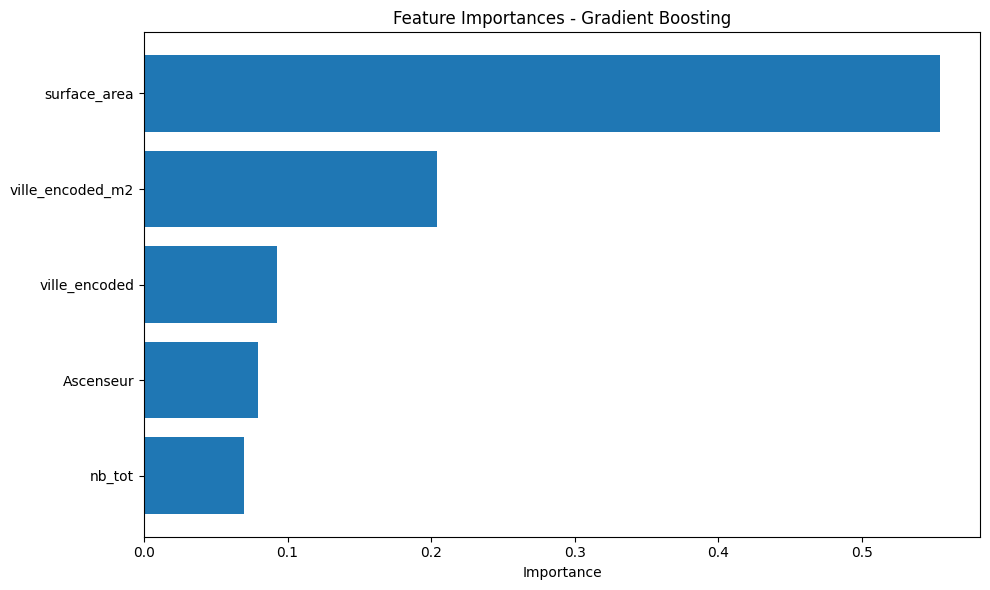

In [30]:
gbm_model = best_model.named_steps['model'].regressor_

print(type(gbm_model))

importances = gbm_model.feature_importances_
feature_names = X_train.columns


df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(df_importance)

plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'][::-1], df_importance['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting")
plt.tight_layout()
plt.show()

## Visualisation de la courbe d'apprentissage

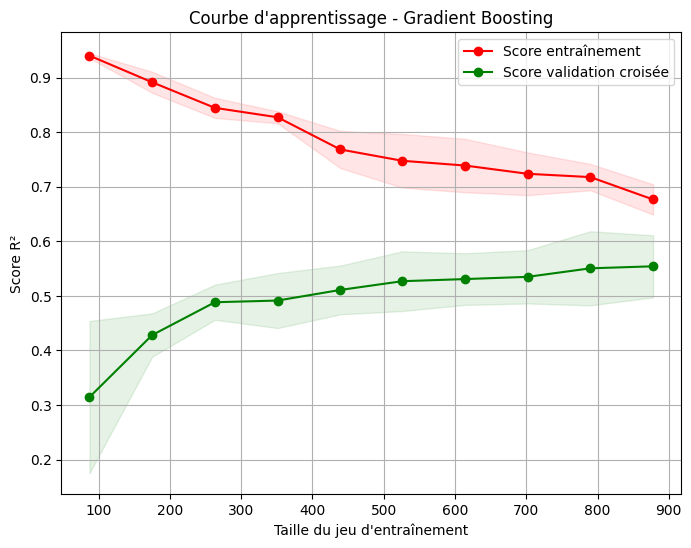

In [31]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=3,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Courbe d'apprentissage - Gradient Boosting")
plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("Score R²")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score entraînement")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Score validation croisée")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.legend(loc="best")
plt.show()



## Sauvegarde du modèle

In [32]:
joblib.dump(best_model, 'model.pkl')
print("Modèle sauvegardé dans model.pkl")

Modèle sauvegardé dans model.pkl
